<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/%EC%8A%B9%ED%98%9C/img_preprocessing_def(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# import 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math
# import image_dehazer

# contrast 함수 

In [71]:
# contrast 함수
def contrast_roi(img, low, high):
    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (img[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    return img_

# brightness 함수

In [72]:
  def bright_ness(img):
    cols, rows = img.shape[:2]
    brightness = np.sum(img) / (255 * cols * rows)
    return brightness

# mask & rotate

In [73]:
# 마스크 생성
def make_mask(img):
    #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img1 = img.copy()

    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    
    #블러 02
    #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img1.mean()*0.5)//2)*2+1
    img1 = cv2.medianBlur(img1, blur_k)
    
    # threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    #이미지 평균값을 기준으로 이진화 04

    if img1.mean() > 100 : 
      th = img1.mean()*0.94
    else : 
      th = img1.mean()

    ret, img1 = cv2.threshold(img1, th, 255, cv2.THRESH_BINARY)

    #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img1.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    # 커널만들어서 팽창연상 적용
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    mask = cv2.dilate(mask,k) #팽창연산

    return mask

In [74]:
# 마스크 기준으로 자르기
def cut_mask(img, mask):
    img2 = img.copy()
    height, width = img2.shape[:2]
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    # img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 

    img2 = img2[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]
    masked = cv2.bitwise_and(img2, mask) #이미지에서 배경을 지우는 연산
    # print(img.shape)
    # print(mask.shape)

    return masked


In [75]:
def masked_ro(img):
    img3 = img.copy()
    h, w = img3.shape[:2]
    img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()

    # ret, th = cv2.threshold(img3, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()

    # 회전 1단계
    # 밑에서부터 처음으로 검은 색이 나오는 부분이 lower
    for i in reversed(range(h)):
        if th_li[i][0] == 0 and th_li[i][-1] == 0:
            lower = i
            break

    # 만약 맨 밑이 lower면 이미지의 95퍼센트 부분을 lower로 정의
    if lower == h - 1:
        lower = int(h*0.9)

    # upper는 lower에서 5퍼센트만큼 올라간 부분
    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # x, y좌표들은 이미지의 90퍼센트(upper)와 95퍼센트(lower) 부분의 손목 가운데 지점들
    x,y = [],[]
    for i in range(slice5):
        cnt = th_li[i + upper].count(255)
        index = th_li[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # x,y좌표로 단순선형회귀 그리기
    model = LinearRegression()
    model.fit(X=x,y=y)

    # -----------------------------------------------------------------------------------
    # 회전 2단계
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2), angle-90, 1)
    rotate = cv2.warpAffine(img3, M, (w, h))

    # 회전한 부분을 자르기
    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = max(s_point, e_point)
    img_ro = rotate[:point]
    return img_ro

In [76]:
def preprocession_img_ro(img):
    mask = make_mask(img)
    masked = cut_mask(img, mask)
    img_ro = masked_ro(masked)
    return img_ro

In [77]:
# img= preprocession_img_ro(img)
# plt.figure(figsize=(7,6))
# plt.imshow(img)
# plt.show()

# total 함수

In [85]:
# 이미지 1개 가져오기
from google.colab import files
uploaded = files.upload()

Saving 400_F.jpg to 400_F.jpg


In [97]:
# 이미지 1개 img 적용
img = cv2.imread('400_F.jpg',cv2.IMREAD_COLOR)

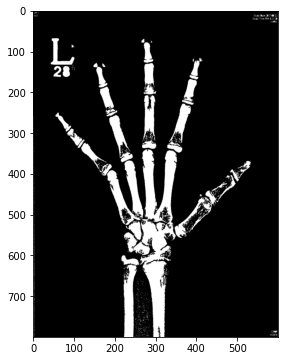

In [98]:
# 이미지 전처리 함수 (img, 모폴로지값1, 모폴로지값2, 필터값(d,e))
def merong(img,a,b,d,e):
  # 이미지 가져오기
  # img = cv2.imread('1_F_손목 - 복사본.jpg',cv2.IMREAD_COLOR)
  img1 = img
  # 밝기 조정
  if bright_ness(img1) > 0.8:
    img1 = np.clip(img1 - 80., 0, 255).astype(np.uint8)
  elif bright_ness(img1) > 0.75:
    img1 = np.clip(img1 - 50., 0, 255).astype(np.uint8)
  elif bright_ness(img1) > 0.65:
    img1 = np.clip(img1 - 30., 0, 255).astype(np.uint8)
  else: img1 = np.clip(img1 - 10., 0, 255).astype(np.uint8)
  # plt.imshow(img1)
  # plt.show()
  
  # dehazing (must be a color image)
  # img1 = image_dehazer.remove_haze(img1)		# Remove Haze

  # 이미지 Lab
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)

  # 모폴리지
  k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
  img1 = cv2.morphologyEx(img1, cv2.MORPH_TOPHAT, k) # 밝기 값이 크게 튀는 곳을 강조

  # 필터
  img1 = cv2.bilateralFilter(img1,-1, d, e)
  # img1= guided_Fitler(img1, img1, r=3, eps=100)

  # Lab to gray for binary
  img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  # 정규화
  img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX)

  # 평탄화 (Clahe)
  img1 = cv2.equalizeHist(img1)
  clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) #CLAHE 생성
  img1= clahe.apply(img1)           #CLAHE 적용


  # binary
  ret, mask = cv2.threshold(img1,
                            np.mean(img1), # thresh= 이미지의 평균값을 임계치로
                            255,
                            cv2.THRESH_BINARY) # ret - 임계값, mask = img마스크
  
  # 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
  contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                         cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                         cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 

  cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


  # plt.imshow(mask)
  # plt.show()










  #### 강 조
  img2 = img.copy()
  if bright_ness(img2) > 0.8:
    img2 = np.clip(img2 - 80., 0, 255).astype(np.uint8)
  elif bright_ness(img2) > 0.75:
    img2 = np.clip(img2 - 50., 0, 255).astype(np.uint8)
  elif bright_ness(img2) > 0.65:
    img2 = np.clip(img2 - 30., 0, 255).astype(np.uint8)
  else: img2 = np.clip(img2 - 10., 0, 255).astype(np.uint8)


  # 모폴로지
  k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
  img2 = cv2.morphologyEx(img2, cv2.MORPH_TOPHAT, k2)

  # contrast
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  if img2.mean() <= 15:
      low = img2.mean() * 3.2
      high = img2.mean() * 3.6
  elif img2.mean() <= 20:
      low = img2.mean() * 3
      high = img2.mean() * 3.6
  else:
      low = img2.mean() * 3
      high = img2.mean() * 3.7

  img2 = cv2.blur(img2,(2,2))
  img2 = contrast_roi(img2, low, high)



    
  # # 뼈강조하고 마스크랑 비트 연산
  # # 모폴로지
  # k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (c, c))
  # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)


  # 컨투어
  contours, hierarchy = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img2, contours, -1, (255, 255, 255), -1)

  # 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
  img2 = cv2.bitwise_and(img2, mask) 
  # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
  img2 = cv2.blur(img2,(2,2))
  img2 = cv2.resize(img2, (600, 800))

  plt.figure(figsize=(8,6))
  plt.imshow(img2,'gray')
  plt.show()

merong(img,60,55,50,25)


# path설정으로 폴더 사진 전체에 적용 

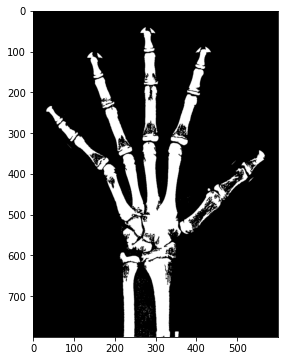

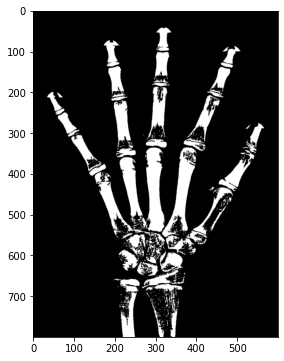

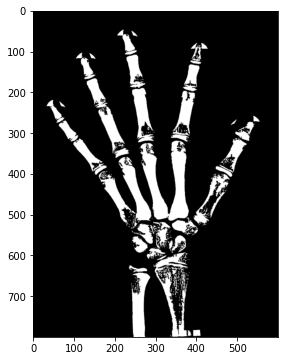

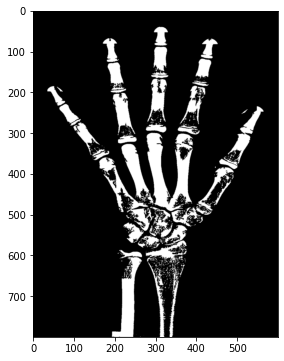

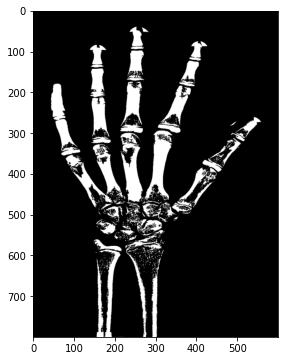

In [99]:
for i in range(400,405):
  img_path = "/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/image/Female/"
  img = cv2.imread(img_path+f"{i}_F.jpg", cv2.IMREAD_COLOR)
  img= preprocession_img_ro(img)
  merong(img,60,55,50,25)

['409_F.jpg', '407_F.jpg', '408_F.jpg', '406_F.jpg', '405_F.jpg', '404_F.jpg', '402_F.jpg', '403_F.jpg', '401_F.jpg', '400_F.jpg', '399_F.jpg', '398_F.jpg', '396_F.jpg', '395_F.jpg', '394_F.jpg', '393_F.jpg', '392_F.jpg', '397_F.jpg', '391_F.jpg', '390_F.jpg', '389_F.jpg', '388_F.jpg', '387_F.jpg', '386_F.jpg', '385_F.jpg', '383_F.jpg', '384_F.jpg', '381_F.jpg', '380_F.jpg', '382_F.jpg', '379_F.jpg', '378_F.jpg', '377_F.jpg', '375_F.jpg', '376_F.jpg', '373_F.jpg', '372_F.jpg', '371_F.jpg', '374_F.jpg', '367_F.jpg', '369_F.jpg', '368_F.jpg', '370_F.jpg', '365_F.jpg', '361_F.jpg', '364_F.jpg', '362_F.jpg', '363_F.jpg', '366_F.jpg', '359_F.jpg', '356_F.jpg', '358_F.jpg', '352_F.jpg', '360_F.jpg', '354_F.jpg', '353_F.jpg', '345_F.jpg', '355_F.jpg', '347_F.jpg', '351_F.jpg', '349_F.jpg', '350_F.jpg', '346_F.jpg', '348_F.jpg', '341_F.jpg', '342_F.jpg', '344_F.jpg', '343_F.jpg', '357_F.jpg', '339_F.jpg', '340_F.jpg', '338_F.jpg', '336_F.jpg', '337_F.jpg', '308_F.jpg', '333_F.jpg', '331_F.jpg'

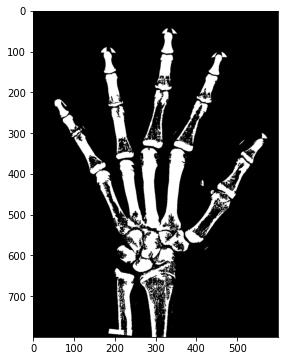

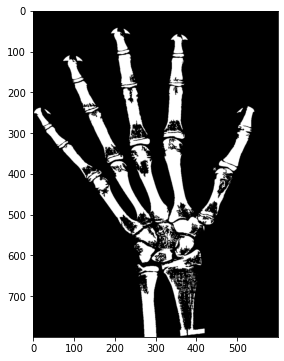

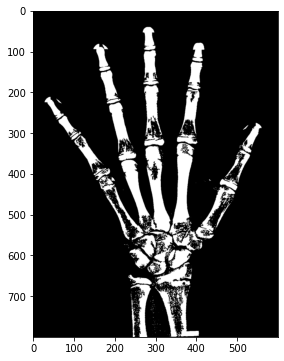

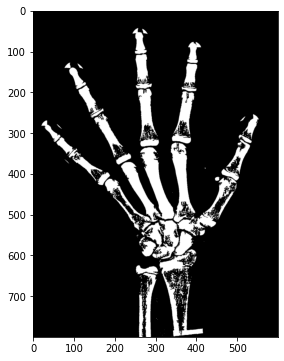

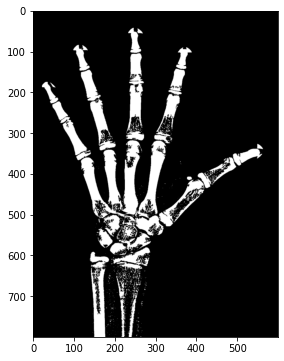

In [63]:
# 이미지 여러개에 함수 적용
import os
path = '/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/image/Female'
dir_list = os.listdir(path)
print(dir_list)

# 빼고싶은 개수만큼 [:x] 로 적어주세요
for item in dir_list[:5] :   
  img = cv2.imread(path+'/'+f'{item}',cv2.IMREAD_COLOR)
  img= preprocession_img_ro(img)
  merong(img,60,55,25,10) # 이건 다 잘되지롱
